The following code template comes with placeholders (marked with `YOUR CODE HERE`) and has to be filled with the appropriate logic as described in the function descriptions.
Some cells consist of assertions about the expected functionality, and aid you in getting it right.
They are not meant to be edited.
Moreover, there are also hidden assertions that will test your environment for edge cases.
Each correct assertion rewards you points for this assignment.

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "SHIVARAM GOUTHAM SURESH"
COLLABORATORS = "PRAMOD MAHAJAN CHIKKABALLEKERE MANJUNATHA"

_Please note that only one collaborator is allowed in all assignments, that is, only two persons per group. We expect independent submissions per group. All deviations will be sanctioned._

---

# Control a Brew Pump
In this homework assignment you are supposed to write an algorithm that controls a permanently excited DC motor, which is deployed in a brewery for filling barrels with their finest branded beer.
The motor is installed on a pump wheel controlling flow rates with its motor speed.
In order to maximize efficiency of infilling, the motor's speed shall be controlled and follow a certain set trajectory.

You, as an engineer of BarrelFilling Inc., are tasked with setting up the control with state-of-the-art techniques, following the high-tech culture of your company.
You decide to deploy a reinforcement learning algorithm for this manner.

![](tenor.gif)

### Motor and Load Equations

The equivalent circuit diagram of a permanently excited DC motor is as follows:

![](ESB_permex_dcm.png)

The electrical ODE is described by (abbreviating $i_a = i$ and $u_a = u$):

$$\frac{\partial i}{\partial t} = \frac{u - \mathit{\Psi}_e \omega - R_a i}{L_a}$$

while torque is calculated by:
$$T = \mathit{\Psi}_e i$$

In case of the permanently excited motor, a permanent magnet with constant $\mathit{\Psi}_e$ replaces the excitation circuit.
Hence, torque scales directly with the current.

The mechanical ODE (beer flow friction) is described by:

$$\frac{\partial \omega}{\partial t} = \frac{T - T_L(\omega_{me})}{J_{total}}$$

with $J_{total}$ being the mechanical system's moment of inertia and where the load torque $T_L$ is polynomial in this task:

$$ T_L(\omega_{me}) = sign(\omega_{me})(c\omega_{me}^2 + b|\omega_{me}| + a) $$

In this assignment, a motor-speed-controlling agent is to be designed, rather than implementing the physical ODEs.
That is readily available as an environment.


### Converter
For this specific DC motor we are going to apply an [H-bridge converter](https://en.wikipedia.org/wiki/H-bridge).
Although this converter technically provides four different discrete operation points (switching pair states), the motor will be able to distinguish between three only:
* Applied voltage:
  *  $u = +u_{DC}$
  * $u = 0 $ V
  * $u = -u_{DC}$
  
This translates to three discrete actions from which an agent can choose at any given time.



The RL motor environment will be provided by [Gym Electric Motor](https://github.com/upb-lea/gym-electric-motor).
Please install it by 
```py
pip install gym-electric-motor
```

## 1. $n$-step Q-Learning Agent (10 points)

Implement the missing logic in the following cell. Make sure to read the function descriptions thoroughly and check back with the visible assertions in the next cells for correct implementation.

Be aware, that there are also invisible assertions that check your implementation for edge cases. Those should be inferable from function descriptions though.


The control of a permanently-excited DC motor is a non-episodic task with continous states.
In order to apply the Q-Learning algorithm, we need to utilize a converter with discrete actions and quantize the state space (which is already provided in the template below).

In [2]:
import gym_electric_motor as gem
from gym_electric_motor import reference_generators as rg
from pprint import pprint
from tqdm.auto import tqdm
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import random

np.set_printoptions(linewidth=50)
plt.style.use('dark_background')


observed_states = ['omega', 'i']

class ConstantLimitViolationReward(gem.reward_functions.WeightedSumOfErrors):
    def _limit_violation_reward(self, state):
        return -1500

class QLearningAgent:
    """This class represents the n-step Q-Learning algorithm.
    In each step, it is called with 'decide' to choose an action and with 'deliberate' 
    after observing the environment's response to make any appropriate updates."""
    
    # Q-Learning algorithm config parameters
    epsil = 0.1  # epsilon for action selection
    alpha = 0.5  # update step length
    observed_states = observed_states
    gamma = 0.9  # discounting factor
    
    def __init__(self, environment, q=40, range_to_quantize=(-1.3, 1.3), n_steps=1):
        """The agent is initialized with the environment, the n-step config, and 
        quantization parameters. Quantizing with q levels leads to q discrete fields into 
        which each continous state can fall within the range defined by range_to_quantize."""
        self.n_actions = 3  # +u_DC, 0V, -u_DC
        self.n_steps = n_steps
        n_observations = sum(sum(n.shape) for n in environment.observation_space)
        # memory
        self.t = 0  # time steps in episode (necessary for n-step algo)
        # ringbuffer for observed rewards
        self.last_rewards = deque(maxlen=n_steps)  
        # ringbuffer for discrete observations and actions
        self.last_observation_actions = deque(maxlen=n_steps)  
        
        # quantization config
        self.quantization_level = q
        self.range_to_quantize = range_to_quantize
        a, b = range_to_quantize
        self.quant_bins = np.linspace(a, b, q)
        
        # the internal Q table that is being learned
        self.Q_tab = np.zeros(n_observations * [self.quantization_level + 1] +
                              [self.n_actions], dtype=np.float32)
        # a boolean switch between epsilon-greedy (training) and greedy (testing)
        self.training_mode = True
    
    def preprocess(func):
        """This function wraps the agent's 'decide' and 'deliberate' function."""
        def wrapper(self, state, reference, *args, **kwargs):
            
            # instead of the reference, observe the control error
            actual_omega = state[self.observed_states.index('omega')]
            obs = np.clip(np.concatenate((state, actual_omega-reference)), *self.range_to_quantize)
            # quantize observation
            obs_q = tuple(np.digitize(obs, self.quant_bins) - 1)
            return func(self, obs_q, *args, **kwargs)
        return wrapper
    
    @preprocess
    def decide(self, observation):
        """Given the observation, choose an action epsilon-greedily.
        Store the observation and the corresponding action in 
        self.last_observation_actions."""
        # YOUR CODE HERE
        if self.epsil  < np.random.rand(1):
            action = np.argmax(self.Q_tab[observation])
        else:
            action = random.choice(range(3))
        self.last_observation_actions.append(observation+(action,))
        
        return action
    
    @preprocess
    def deliberate(self, observation, reward=0, done=False):
        """Given the next observation, reward and the 'done'-flag, update 
        the Q-table. Store the reward in the ring buffer 'self.last_rewards'.
        Increment 'self.t' to keep track where in the episode we are.
        For this function's implementation the '_update' function can be used
        optionally."""
        # YOUR CODE HERE
        if not done:    
            self.last_rewards.append(reward)
            self.t += 1
            tau = self.t - self.n_steps + 1
            if tau >= 0:           
                if not done:
                    idx_range = np.arange(tau + 1, tau + self.n_steps + 1) 
                    n_rewards = list(self.last_rewards)
                
                g = np.sum([self.gamma ** (i-tau-1) * r for i, r in zip(idx_range, n_rewards)])
            
                if not done:     
                    g += self.gamma ** self.n_steps * np.max(self.Q_tab[observation])
                    temp_id1 = self.last_observation_actions.popleft()
                    
                    self.Q_tab[temp_id1] += self.alpha * (g - self.Q_tab[temp_id1])
                    self.t = 0
                    self.last_observation_actions.clear()
                    self.last_rewards.clear()
        else:
            self.t = 0
            self.last_observation_actions.clear()
            self.last_rewards.clear()
                
        

    def _update(self, _observation, _reward=0, _done=False):
        """Optional auxiliary function to implement the 'deliberate' logic.
        If you do not see any use in this helper function, just leave it."""
        
        # YOUR CODE HERE
        raise NotImplementedError()

In [3]:
# This cell demonstrates the agent's usage. No exceptions shall be thrown. 

env = gem.make('DcPermExDisc-v1',
    motor_parameter=dict(r_a=2.5, l_a=5e-2, psi_e=7),
    limit_values=dict(torque=175),
    tau=5e-4,
    load_parameter=dict(a=.1, b=.01, c=0.001, j_load=1e-8),
    state_filter=observed_states,
    ode_solver='euler', solver_kwargs=dict(),
    reward_function=ConstantLimitViolationReward(),
    reference_generator=rg.StepReferenceGenerator(reference_state='omega', amplitude_range=(.1,.1),
                                                  frequency_range=(1e1, 2e1), offset_range=(.8,.8),
                                                  limit_margin=None, episode_lengths=1000)
    )

controller = QLearningAgent(env, n_steps=1)

# TRAINING
def conduct_training(_controller, n_episodes=3000, episode_len=200):
    _controller.training_mode = True
    train_log = {'cum_rew': [], 'lengths': []}
    for ep in tqdm(range(n_episodes)):
        state, reference = env.reset()
        cum_rew = 0
        for i in range(episode_len):

            action = _controller.decide(state, reference)
            (state, reference), reward, done, _ = env.step(action)
            _controller.deliberate(state, reference, reward, done or i == episode_len - 1)
            cum_rew += reward
            
            if done: break
        train_log['cum_rew'].append(cum_rew)
        train_log['lengths'].append(i)
    return train_log

logs_train = conduct_training(controller)


C:\Anaconda\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
# This cell demonstrates the agent's usage. No exceptions shall be thrown. 
# TESTING   
def conduct_testing(_controller, n_episodes=5, episode_len=500):
    _controller.training_mode = False
    log = {}
    eps_tested = 0
    for ep in tqdm(range(n_episodes)):
        ep_log = {'state': [], 'ref': [], 'rew': []}
        state, reference = env.reset()
        cum_rew = 0
        for n in range(episode_len):
            action = _controller.decide(state, reference)
            (state, reference), reward, done, _ = env.step(action)
            cum_rew += reward
            ep_log['state'].append(state)
            ep_log['ref'].append(reference)
            ep_log['rew'].append(cum_rew)
            if done: break
        eps_tested += 1
        #if n > 0.6*episode_len:
        log[eps_tested] = ep_log
    print(f'tested for {eps_tested} episodes')
    return log

logs_test = conduct_testing(controller)


tested for 5 episodes


In [5]:
# self.t should be updated accordingly
n = 100
agent = QLearningAgent(env, n_steps=n)
state, reference = env.reset()
for i in range(1, 2*n):
    action = 2
    (state, reference), reward, done, _ = env.step(action)
    done = done or i == 2*n-1
    agent.deliberate(state, reference, reward, done)
    if done:
        assert agent.t == 0
        break
    else:
        assert agent.t == i

In [6]:
# This cell contains hidden tests. Please ignore and do not alter this cell.


In [7]:
# This cell contains hidden tests. Please ignore and do not alter this cell.

In [8]:
# This cell contains hidden tests. Please ignore and do not alter this cell.

In [9]:
# This cell contains hidden tests. Please ignore and do not alter this cell.

In [10]:
# This cell contains hidden tests. Please ignore and do not alter this cell.

In [11]:
# This cell contains hidden tests. Please ignore and do not alter this cell.

## 2. Plot Training and Validation Logs (10 points)
Your boss, Elliot Maske, tasks you with reporting the current algorithm's training and validation performance, in order to evaluate its usefulness.
In the following make readable plots of the training and testing logs.

### Train Logs (3 points)
Show the reward over episodes as well as the episode lengths over episodes.

Make sure to add axes labels (with appropriate unit description), to have a suitable axes scaling/limiting and add a grid.

The rest is your creative choice but you will be rated for readability.

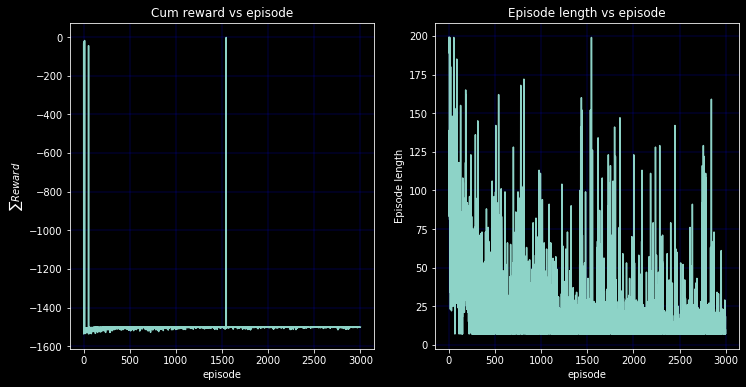

In [12]:
#YOUR CODE HERE
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(6)
fig.set_figwidth(12)

ax1.plot(logs_train['cum_rew'])
ax1.set_title('Cum reward vs episode')
ax1.set_xlabel("episode")
ax1.set_ylabel("$\sum Reward$")
ax1.grid(color='b', ls = '-', lw = 0.25)

ax2.plot(logs_train['lengths'])
ax2.set_title('Episode length vs episode')
ax2.set_xlabel("episode")
ax2.set_ylabel("Episode length")
ax2.grid(color='b', ls = '-', lw = 0.25)

### Validation Logs (7 points)
Showcase five validation trials from the test logs.
* All states and the cumulative reward are to be plotted above/next to each other accordingly.
* Ensure correct labeling of columns and rows among multiple plots.
* Plot actual and reference omega in one figure for each validation trial.
  * Make sure to distinguish them accordingly.
  * Add a legend.
* In the current 'i' plots, indicate quantization bins but do not lose readability of the actual current trajectory.
* In the reward plots, add a small test box labeled "MSE: xx" and replace "xx" with the actual mean squared error between the cumulative reward and the perfect reward (0 all the time, represented by x-axis).
* Normalized quantities are to be labeled with p.u. (per unit) additionally instead of the actual unit.
* There are bonus points for compactness.

iteration : 1


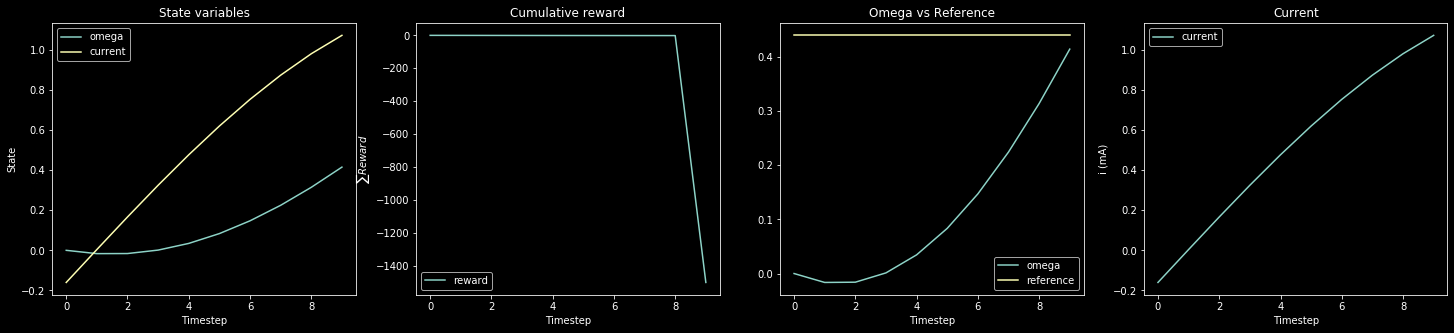

iteration : 2


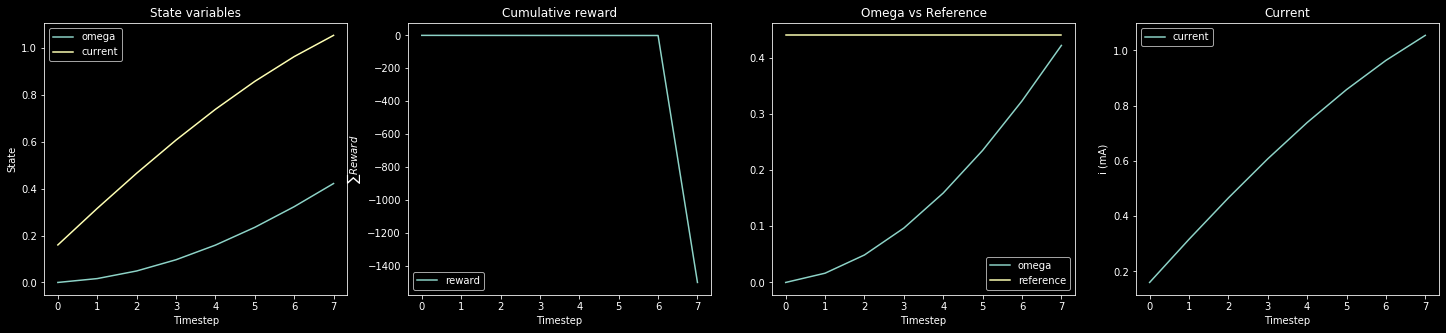

iteration : 3


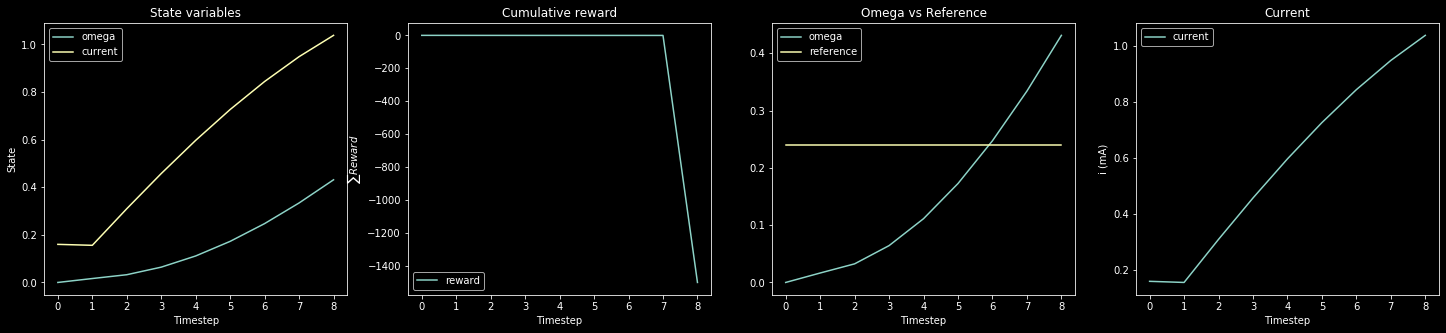

iteration : 4


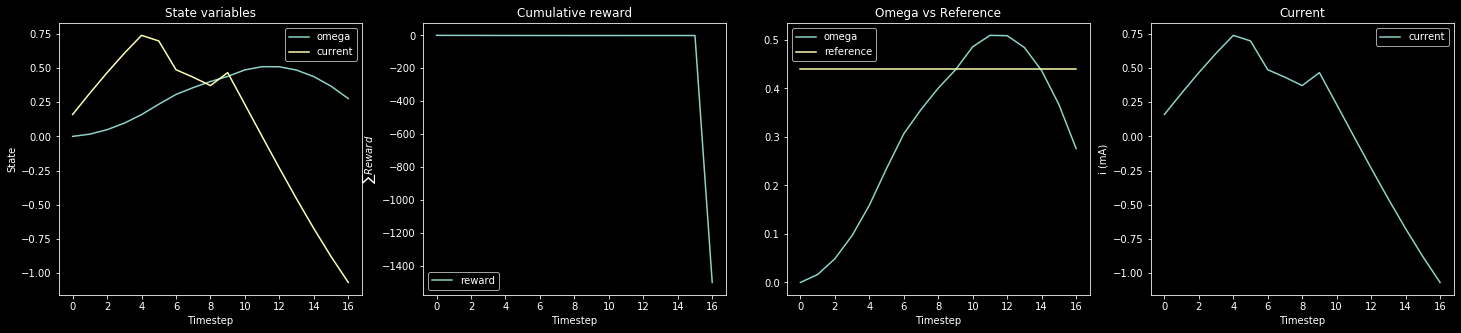

iteration : 5


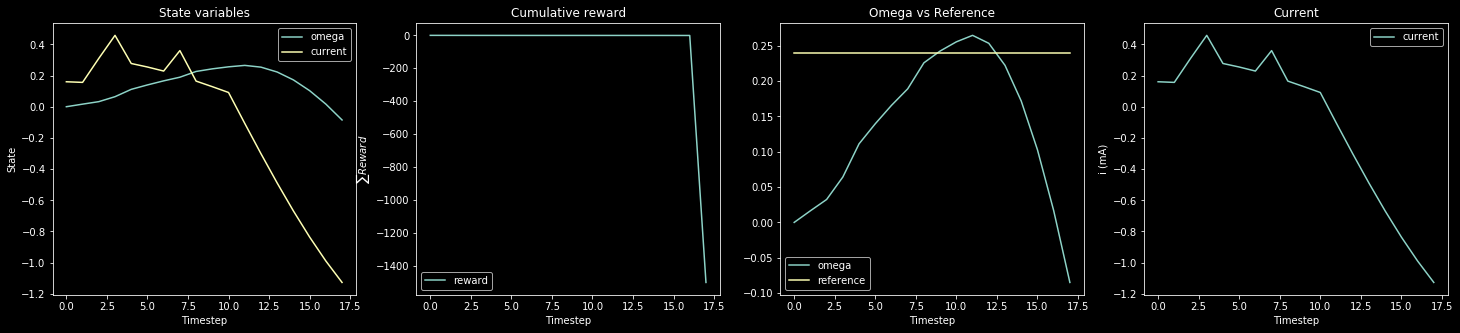

In [13]:
# YOUR CODE HERE

actual_omega = []
current = []
reference = []
reward = []

for i in range(1,6):
    temp_omega = []
    temp_current = []
    for j in range(len(logs_test[i]['state'])):
        temp_omega.append(logs_test[i]['state'][j][0])
        temp_current.append(logs_test[i]['state'][j][1])
    actual_omega.append(temp_omega)
    current.append(temp_current)
    reference.append(logs_test[i]['ref'])
    reward.append(logs_test[i]['rew'])
    
for i in range(5):
    print('iteration : ' + str(i+1))
    fig, ax = plt.subplots(1, 4, figsize=(25,5))
    ax[0].plot(actual_omega[i], label='omega')
    ax[0].plot(current[i], label='current')
    ax[0].set_xlabel("Timestep")
    ax[0].set_ylabel("State")
    ax[0].legend()
    ax[0].set_title("State variables")
    
    ax[1].plot(reward[i], label='reward')
    ax[1].set_xlabel("Timestep")
    ax[1].set_ylabel("$\sum Reward$")
    ax[1].legend()
    ax[1].set_title("Cumulative reward")

    ax[2].plot(actual_omega[i], label='omega')
    ax[2].plot(reference[i], label='reference')
    ax[2].set_xlabel("Timestep")
    ax[2].legend()
    ax[2].set_title("Omega vs Reference")
    
    ax[3].plot(current[i], label='current')
    ax[3].set_xlabel("Timestep")
    ax[3].set_ylabel("i (mA)")
    ax[3].legend()
    ax[3].set_title("Current")
    plt.show()

## 3. Hyperparameter Optimization (10 points)
Being informed by the current performance, your boss demands an improvement.
You suggest to optimize the algorithm's hyperparameters.

In the following, hyperparameters are to be optimized and presented in an approriate manner.

### Grid Search
Sample five equidistant points from *n_steps* and *alpha* (boundaries arbitrary) each.
For each of the 25 combinations, evaluate the agent's performance.
Present the optimum in an easy to digest way.

Readability of the plot(s) will be rated.

### Random Search
As grid search is very exhaustive and becomes computationally intractable for more hyperparameters, we go over to random search for optimizing over all hyperparameters.
Sample in total 25 randomly chosen points from the full range of the following hyperparameters:
* alpha
* n_steps
* gamma
* epsilon

Set the boundaries to reasonable values.
For each of the 25 combinations, evaluate the agent's performance.
Present the optimum in an easy to digest way.

Readability of the plot(s) will be rated.


Grid search result: 
Optimum value for n_steps & alpha are:  13.0 ,  0.7000000000000001


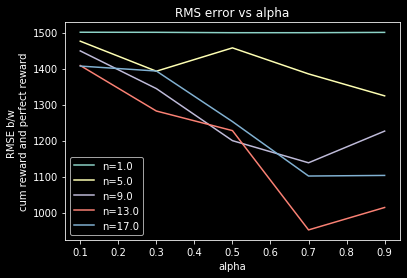

In [14]:
# Grid search

def root_mean_square_error(v1, v2=0):
    return np.sqrt(np.square(v1 - v2).mean())


i = 0
n_step = 20
alpha_max = 1
n_s = np.arange(1, n_step, n_step/5)
alpha = np.arange(0.1,alpha_max,alpha_max/5)
rmse_reward = np.zeros([len(n_s), len(alpha)])

for n_id, n in enumerate(n_s):
    for alpha_id, alp in enumerate(alpha):
        controller_1 = QLearningAgent(env, n_steps=int(n))
        controller_1.alpha = alp
        logs_hp = conduct_training(controller_1)
        rmse_reward[n_id, alpha_id] = root_mean_square_error(np.array(logs_hp['cum_rew']))

opt_n = n_s[int(np.where(rmse_reward == np.min(rmse_reward))[0])]
opt_alpha = alpha[int(np.where(rmse_reward == np.min(rmse_reward))[1])]
print("Grid search result: \nOptimum value for n_steps & alpha are: ", opt_n, ", ", opt_alpha)


yn0 = rmse_reward[0]
yn1 = rmse_reward[1]
yn2 = rmse_reward[2]
yn3 = rmse_reward[3]
yn4 = rmse_reward[4]
x = alpha

plt.plot(x, yn0, label = "n=" + str(n_s[0]))
plt.plot(x, yn1, label = "n=" + str(n_s[1]))
plt.plot(x, yn2, label = "n=" + str(n_s[2]))
plt.plot(x, yn3, label = "n=" + str(n_s[3]))
plt.plot(x, yn4, label = "n=" + str(n_s[4]))
plt.title("RMS error vs alpha")
plt.xlabel("alpha")
plt.ylabel("RMSE b/w \ncum reward and perfect reward")
plt.legend()
plt.show()


Combination 1 : n_steps= 29 , aplha= 0.7077839300924731 , gamma= 0.4889726770775107 , epsilon= 0.6551562915822923



Combination 2 : n_steps= 18 , aplha= 0.8037328068866169 , gamma= 0.48199370804260067 , epsilon= 0.029564362660550847



Combination 3 : n_steps= 15 , aplha= 0.23834912251725737 , gamma= 0.8078831624518417 , epsilon= 0.8169066105109831



Combination 4 : n_steps= 22 , aplha= 0.6397943527561958 , gamma= 0.7892651984178388 , epsilon= 0.9185030285079097



Combination 5 : n_steps= 16 , aplha= 0.8404723901830982 , gamma= 0.3408794254080346 , epsilon= 0.5416949249044086



Combination 6 : n_steps= 27 , aplha= 0.028126351721574183 , gamma= 0.1958078833667266 , epsilon= 0.7210319919067318



Combination 7 : n_steps= 31 , aplha= 0.39159101449912825 , gamma= 0.7258662961409721 , epsilon= 0.8190954174172387



Combination 8 : n_steps= 20 , aplha= 0.9921693791702251 , gamma= 0.15497794252973318 , epsilon= 0.02650330418419322



Combination 9 : n_steps= 16 , aplha= 0.05565475634707151 , gamma= 0.32445701103516356 , epsilon= 0.5249945325312254



Combination 10 : n_steps= 22 , aplha= 0.5941584623583809 , gamma= 0.7371432515102126 , epsilon= 0.1395495415124688



Combination 11 : n_steps= 27 , aplha= 0.1884951321884164 , gamma= 0.37635256623261515 , epsilon= 0.8676960340817678



Combination 12 : n_steps= 34 , aplha= 0.17977299555101278 , gamma= 0.7723008673296422 , epsilon= 0.6679288505054767



Combination 13 : n_steps= 7 , aplha= 0.847776567729635 , gamma= 0.95696200650542 , epsilon= 0.4439914717434793



Combination 14 : n_steps= 37 , aplha= 0.720892325687675 , gamma= 0.6465883718302085 , epsilon= 0.5792549986143888



Combination 15 : n_steps= 16 , aplha= 0.9011575462100022 , gamma= 0.9143887286709896 , epsilon= 0.5848035532758906



Combination 16 : n_steps= 25 , aplha= 0.6945771770290627 , gamma= 0.5286725820866665 , epsilon= 0.9339878815172156



Combination 17 : n_steps= 31 , aplha= 0.5035932491155131 , gamma= 0.1315067732133819 , epsilon= 0.4733319395653077



Combination 18 : n_steps= 13 , aplha= 0.4358018083235421 , gamma= 0.04033344575831033 , epsilon= 0.28628347003252774



Combination 19 : n_steps= 8 , aplha= 0.41814453342456603 , gamma= 0.7435957331915413 , epsilon= 0.015348390382693977



Combination 20 : n_steps= 34 , aplha= 0.21217428726277043 , gamma= 0.7211052196376144 , epsilon= 0.14488194632291895



Combination 21 : n_steps= 9 , aplha= 0.3111877616114971 , gamma= 0.5304815194197199 , epsilon= 0.85435623905817



Combination 22 : n_steps= 10 , aplha= 0.6394512129878871 , gamma= 0.4402131341260329 , epsilon= 0.39517531355975555



Combination 23 : n_steps= 32 , aplha= 0.5371418555327478 , gamma= 0.26404786730309504 , epsilon= 0.3318713037146993



Combination 24 : n_steps= 32 , aplha= 0.8742711457477614 , gamma= 0.19575385061091433 , epsilon= 0.2936184965117814



Combination 25 : n_steps= 19 , aplha= 0.17461498528746633 , gamma= 0.9464952126621656 , epsilon= 0.1984675523013959



Random search result: 
Optimum values are: 
n_steps = 8 
alpha = 0.41814453342456603 
gamma = 0.7435957331915413 
epsilon = 0.015348390382693977


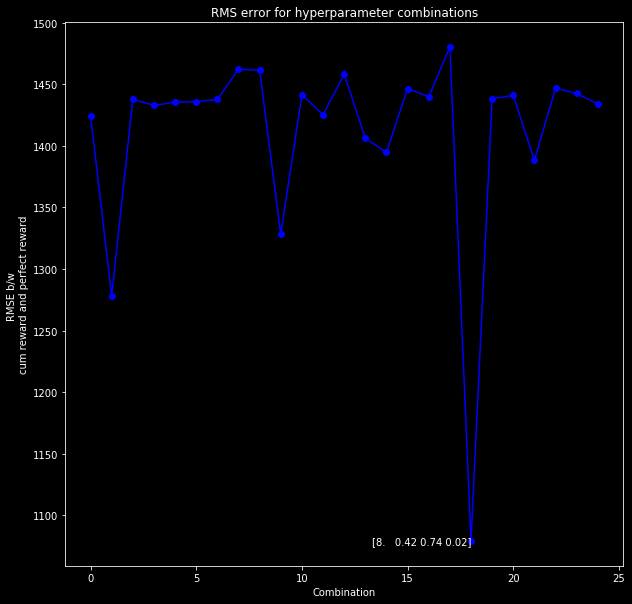

In [15]:
# Random search

def root_mean_square_error(v1, v2=0):
    return np.sqrt(np.square(v1 - v2).mean())

rmse_reward_rand = np.zeros(25)
hyper_parameters = []

for i in range(25):
    n_steps = np.random.randint(1,40)
    alpha = np.random.uniform(0,1)
    gamma = np.random.uniform(0,1)
    epsilon = np.random.uniform(0,1)
    hyper_parameters.append((n_steps, alpha, gamma, epsilon))
    print("Combination " + str(i+1), ": n_steps=", hyper_parameters[i][0], ", aplha=", hyper_parameters[i][1],
         ", gamma=", hyper_parameters[i][2], ", epsilon=", hyper_parameters[i][3])
    controller_2 = QLearningAgent(env, n_steps=n_steps)
    controller_2.alpha = alpha
    controller_2.gamma = gamma
    controller_2.epsil = epsilon
    logs_hp_rand = conduct_training(controller_2)
    rmse_reward_rand[i] = root_mean_square_error(np.array(logs_hp_rand['cum_rew']))

opt_hyps = hyper_parameters[int(np.where(rmse_reward_rand == np.min(rmse_reward_rand))[0])]
print("Random search result: \nOptimum values are: \nn_steps =", opt_hyps[0], "\nalpha =", opt_hyps[1], "\ngamma =", opt_hyps[2], "\nepsilon =", opt_hyps[3])

x_axis = range(len(hyper_parameters))
plt.figure(figsize=(10,10))
plt.plot(x_axis, rmse_reward_rand, 'b-', marker='o')
if(int(np.argmin(rmse_reward_rand)) >= len(x_axis)//2):
    plt.text(int(np.argmin(rmse_reward_rand)), rmse_reward_rand[int(np.argmin(rmse_reward_rand))], str(np.around(hyper_parameters[int(np.argmin(rmse_reward_rand))],2)), 
             horizontalalignment='right', verticalalignment='center')
else:
    plt.text(int(np.argmin(rmse_reward_rand)), rmse_reward_rand[int(np.argmin(rmse_reward_rand))], str(np.around(hyper_parameters[int(np.argmin(rmse_reward_rand))],2)), 
             horizontalalignment='left', verticalalignment='center')
plt.title("RMS error for hyperparameter combinations")
plt.ylabel("RMSE b/w \ncum reward and perfect reward")
plt.xlabel("Combination")
plt.show()